ULMFiT trained for Stance Detection Task

Can try for other labels too


In [ ]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [ ]:
# !wget 'https://storage.googleapis.com/kaggle-data-sets/2477%2F4140%2Fcompressed%2Ftraining.1600000.processed.noemoticon.csv.zip'
!unzip '/content/kaggle140.zip'

In [ ]:
kaggle140=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',header=None,encoding = "latin-1")

In [ ]:
! wget https://raw.githubusercontent.com/prrao87/tweet-stance-prediction/master/data/semeval2016-task6-trainingdata.txt

In [ ]:
sem_eval = pd.read_csv('/content/semeval2016-task6-trainingdata.txt', delimiter='\t', header=0, encoding = "latin-1")

In [ ]:
# function to convert tweets into ASCII
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
kaggle140.columns = ['col1', 'col2',"col3","Stance","col5","Tweet"]
kaggle140 = kaggle140[['Stance','Tweet']]
# Clean Data and Remove URL's from the tweets
kaggle140 = kaggle140.sample(n=200000,random_state=77)
kaggle140['Tweet'] = kaggle140['Tweet'].apply(clean_ascii)
kaggle140['Tweet'] = kaggle140['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [ ]:
sem_eval=sem_eval[['Stance','Tweet']]

In [ ]:
lang_dt=kaggle140.append(sem_eval, ignore_index=True)

In [ ]:
lang_dt

,Stance,Tweet
0,NO_QUERY,is terrified about exams
1,NO_QUERY,I ate waaaay too many cookies this weekend. I...
2,NO_QUERY,Perfect day.. And i get to spend it at work.
3,NO_QUERY,Lost my phone in yesterdays rockshow at PESIT ...
4,NO_QUERY,Eventful morning/afternoon Now to tackle the ...
...,...,...
202809,AGAINST,"There's a law protecting unborn eagles, but no..."
202810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
202811,AGAINST,How dare you say my sexual preference is a cho...
202812,AGAINST,"Equal rights for those 'born that way', no rig..."


In [ ]:
tdt=pd.read_csv('/content/trainable.csv')
tdt=tdt.rename(columns={'Tweets': 'Tweet','Support':'Stance'})

In [ ]:
lang_dt=lang_dt.append(tdt[['Stance','Tweet']],ignore_index=True)
lang_dt.tail(3)

,Stance,Tweet
209680,1,#metoo4publicity now s c women should also ...
209681,0,d lady behind d #metoo movemnt.... #metoodebat...
209682,0,things that #metoo victims are tired of listen...


In [ ]:
path = Path('/content/')
lang_dt.to_csv(path/'kaggle_train_sub_v2.csv', index=False, header=False)
twitter_lm = TextLMDataBunch.from_csv(path, 'kaggle_train_sub_v2.csv', min_freq=1)
twitter_lm.save()
twitter_lm.show_batch()

idx,text
0,"bank charge . evil bastards . regardless , how you all doing this am ! xxbos @shortyazk that sucks was hoping to see you there and was going to steal you for stewarding again lol . xxbos i received a txt msg in a foreign language from an international # & & thought it was from indonesia , when it was actually from serbia ! xxbos @calicowboy956 hey mister what"
1,"to watch xxbos @chaoseed there need to be more args xxbos xxmaj work sucks sometimes xxbos @phersure i hope you feel more sane later . xxbos @weblivz i guess son trumps over daughter in law xxbos @geneticgenesis xxmaj yes , but unfortunately i can not aid you all in your cause as i am not from the xxup uk and so can not vote # stopthebnp xxbos xxmaj yesterday was"
2,"xxmaj player of the xxmaj tournament & ' today ! xxbos xxmaj nevada my xxmaj haflinger has a ' baby ' cold . xxmaj cough , runny nose . xxmaj started antibiotics when his temp went up xxmaj feeling better yesterday . xxbos @jreyes12 haha that s fact . xxbos @chazzdaddy you are so right xxrep 4 . i 'm so glad xxmaj he lives within me ! xxmaj hope"
3,"do i get to see you again ? xxbos been rescuing a broken biscuit from the bottom of my cup of tea xxbos @marijuana_news xxmaj hey , i 'm emailing you right now . xxmaj let 's sort this out your situation together . xxbos @ladaisyd xxmaj leave my poor baby alone xxbos 5th xxmaj sunday xxmaj singing xxbos xxmaj going to an audition ! xxmaj wish me luck !"
4,xxbos yummy sushi place with the best . bummed to be leaving tomorrow flying outta jfk is a bitch xxbos think i clean the bedroom and living room now - well actually i should do the kitchen and bathroom either but i hate these ones xxbos i hate how dark my hair is xxbos @mitchelmusso hey mitchel c u tmro at walmart.could not make tonite bro . graduated college tonite


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


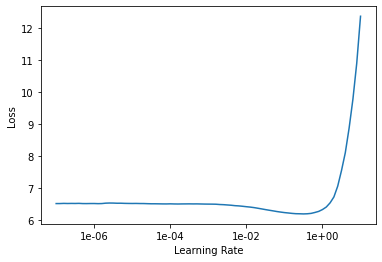

In [ ]:
learn_twitter = language_model_learner(twitter_lm, AWD_LSTM, drop_mult=0.1)
learn_twitter.lr_find(start_lr=1e-8, end_lr=1e2)
learn_twitter.recorder.plot()

In [ ]:
learn_twitter = language_model_learner(twitter_lm, AWD_LSTM,drop_mult=0.5)
learn_twitter.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,5.053822,4.717834,0.208374,09:30


In [ ]:
learn_twitter.unfreeze()
learn_twitter.fit_one_cycle(cyc_len=5, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.592715,4.344318,0.250712,10:37
1,4.383563,4.187261,0.265000,10:37
2,4.192356,4.110231,0.270790,10:38
3,4.029832,4.088607,0.274656,10:38
4,3.928093,4.095024,0.274406,10:37


In [ ]:
# Save the fine-tuned encoder (Uncomment the line given below)
learn_twitter.save_encoder('ft_enc_kaggle_v1')

In [ ]:
#Save the Vocab to a Pickle file for later use
pickle.dump(twitter_lm.train_ds.vocab, open(f'vocab.pkl','wb'))
vocab_load = pickle.load(open('vocab.pkl', 'rb'))

**Training Strats here**

In [ ]:
trainable.to_csv('tt.csv',index=False)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


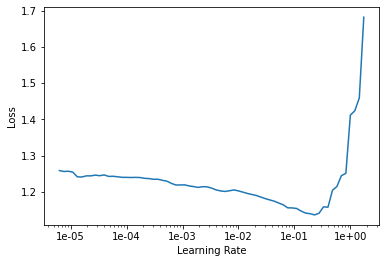

In [ ]:
data_clas = TextClasDataBunch.from_csv(path, '/content/tt.csv', vocab=vocab_load, min_freq=1, bs=64)
data_clas.save()
learn = text_classifier_learner(data_clas,AWD_LSTM ,drop_mult=0.5)
learn.load_encoder('ft_enc_kaggle_v1')
learn.freeze()

#Find Optimum Learning Rate
learn.lr_find(start_lr=1e-6, end_lr=1e2)
learn.recorder.plot()

In [ ]:
#Train the Classifier by Gradually Unfreezing the Layers
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))
    #Unfreeze Layer
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-4,1e-2), moms=(0.8,0.7))
    #Unfreeze Layer
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-5,5e-3), moms=(0.8,0.7))
    #Unfreeze All Layers
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3), moms=(0.8,0.7))
    # get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

epoch,train_loss,valid_loss,accuracy,time
0,1.108155,1.081742,0.432636,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.925905,0.871612,0.606272,00:10
1,0.869928,0.852567,0.606852,00:10
2,0.838431,0.851427,0.606272,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.841839,0.862219,0.607433,00:15
1,0.826976,0.875148,0.600465,00:16
2,0.785392,0.886886,0.595819,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.758142,0.912891,0.582462,00:24
1,0.752605,0.927439,0.577816,00:21
2,0.726572,0.929626,0.577816,00:23


col_0,0,1,2
row_0,,,
0,935,97,496
1,21,3,13
2,88,12,57


In [ ]:
test_orig=pd.read_csv('/content/validation.csv')

In [ ]:
stance=test_orig['Processed_tweets'].apply(lambda row: str(learn.predict(row)[0]))
pd.DataFrame(stance).to_csv('res3.csv')
d=pd.DataFrame(stance)

In [ ]:
#Validation Set
target=pd.read_csv('/content/true_st.csv')['Truth']

In [ ]:
# AUC CAlculation on validation SET
from sklearn.metrics import roc_auc_score
print(roc_auc_score(truth['Support'],d['Support']))
#0
print(roc_auc_score(truth['Oppose'],d['Oppose']))


0.5762153759647981
0.725813602908575


In [ ]:
#predictions for submission
stance=testatable['Processed_tweets'].apply(lambda row: str(learn.predict(row)[0]))

stance.to_csv

0       none
1       none
2       none
3       none
4       none
        ... 
1732    none
1733    none
1734    none
1735    none
1736    none
Name: Processed_tweets, Length: 1737, dtype: object

In [ ]:
# converting multiclass to multilabel ; 
# none maps to -> 0,0 ; Against maps to 0,1; 
# Favour maps to 1,0 for Support & Oppose Respectively

support=[]
oppose=[]

for i in stance:
  if (i=='support'):
    support.append(1)
    pass
  if (i=='oppose'):
    oppose.append(1)
    pass
  else:
    support.append(0)
    oppose.append(0)
    pass
  

In [ ]:
#submission predictions
pd.DataFrame(stance)

,Processed_tweets
0,none
1,none
2,none
3,none
4,none
...,...
1732,none
1733,none
1734,none
1735,none


In [ ]:
#saving the model
!tar -zcvf kaggle_lmodel.tar.gz '/content/models'

tar: Removing leading `/' from member names
/content/models/
/content/models/ft_enc_kaggle_v1.pth
/content/models/tmp.pth
